<a href="https://colab.research.google.com/github/Thanawat-L/DADS/blob/main/DADS6003_ML_week05_yfinance_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4488    0  4488    0     0  20008      0 --:--:-- --:--:-- --:--:-- 20035
100  517k  100  517k    0     0  1231k      0 --:--:-- --:--:-- --:--:-- 1231k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4488    0  4488    0     0  33093      0 --:--:-- --:--:-- --:--:-- 33244
100  392k  100  392k    0     0  1076k      0 --:--:-- --:--:-- --:--:-- 2549k


In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
import yfinance as yf

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
tsm = yf.Ticker('TSM') #Taiwan Semiconductor Manufacturing Company Limited (TSM)
nvidia = yf.Ticker('NVDA') #NVIDIA Corporation (NVDA)

In [4]:
start = '2023-1-1'
end = '2024-1-1'

tsm_df = tsm.history(interval='1h',start=start,end=end)
tsm_df = tsm_df.iloc[:,:4]
nvidia_df = nvidia.history(interval='1h',start=start,end=end)
nvidia_df = nvidia_df.iloc[:,:4]
nvidia_df = nvidia_df.rename(columns={'Open': 'n_Open', 'High': 'n_High', 'Low': 'n_Low', 'Close': 'n_Close'})

display(tsm_df.head())
display(nvidia_df.head())

,Open,High,Low,Close
Datetime,,,,
2023-01-03 09:30:00-05:00,75.849998,75.970001,74.389999,74.510002
2023-01-03 10:30:00-05:00,74.525002,75.040001,74.235703,74.620003
2023-01-03 11:30:00-05:00,74.625000,74.625000,73.779999,73.864998
2023-01-03 12:30:00-05:00,73.870003,74.110001,73.779999,74.099998
2023-01-03 13:30:00-05:00,74.099998,74.169998,73.860001,73.930099


,n_Open,n_High,n_Low,n_Close
Datetime,,,,
2023-01-03 09:30:00-05:00,148.509995,149.960007,143.070007,143.520004
2023-01-03 10:30:00-05:00,143.529999,143.570007,141.030106,141.960007
2023-01-03 11:30:00-05:00,141.949997,142.610001,140.960007,141.830093
2023-01-03 12:30:00-05:00,141.850006,142.860001,141.570007,142.789993
2023-01-03 13:30:00-05:00,142.800095,142.863098,142.029999,142.271698


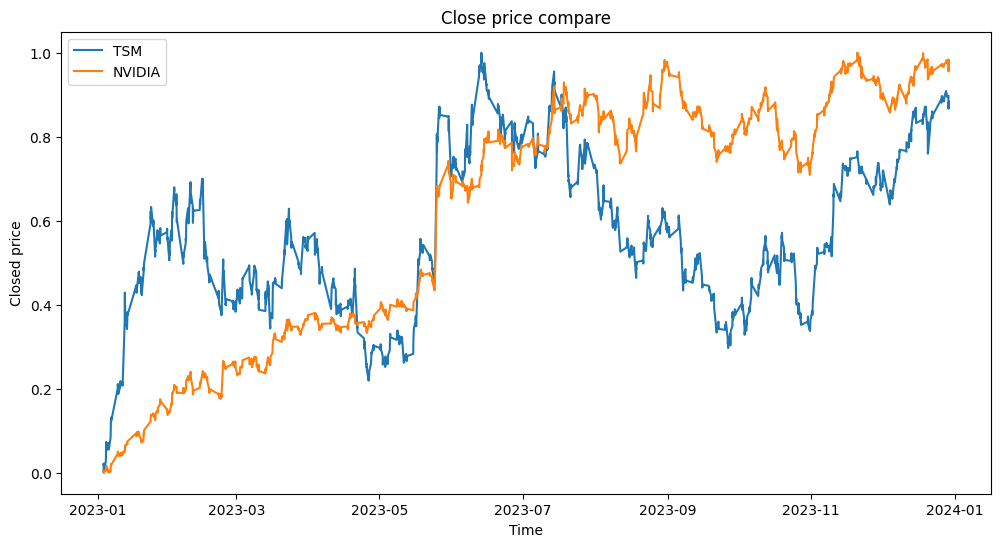

In [5]:
mm_scaler = MinMaxScaler()

tsm_scaled = mm_scaler.fit_transform(tsm_df.loc[:,['Close']])
nvidia_scaled = mm_scaler.fit_transform(nvidia_df.loc[:,['n_Close']])

plt.figure(figsize=(12,6))
plt.title('Close price compare')
plt.plot(tsm_df.index, tsm_scaled, label='TSM')
plt.plot(nvidia_df.index, nvidia_scaled, label='NVIDIA')
plt.xlabel('Time')
plt.ylabel('Closed price')
plt.legend()
plt.show()

In [6]:
df = tsm_df.copy()

df['tsm_S_10'] = df['Close'].rolling(window=10).mean() #mean ของ window frame = 10
df['tsm_Corr'] = df['Close'].rolling(window=10).corr(df['tsm_S_10']) # หา corr ของ mean กับ ราคาปิด window frame = 10
df['tsm_RSI'] = ta.RSI(np.array(df['Close']), timeperiod=10)
df['tsm_Open-Close'] = df['Open'] - df['Close'].shift(1) #ราคาเปิด - ราคาปิด row ก่อนหน้า
df['tsm_Open-Open'] = df['Open'] - df['Open'].shift(1) #ราคาเปิด - ราคาเปิด row ก่อนหน้า
df['tsm_SMA'] = ta.SMA(np.array(df['Close']), timeperiod=10) #smooth out price fluctuations and identify trends. typically the 10-day
df["tsm_upper_band"], df["tsm_middle_band"], df["tsm_lower_band"] = ta.BBANDS(df["Close"], timeperiod=20) #typically the 20-day moving average
#the volatility of an asset and identify overbought and oversold conditions. The bands consist of a moving average
df["tsm_macd"], df["tsm_macd_signal"], df["tsm_macd_hist"] = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9) # It is typically used with a 12-day and 26-day moving average, and a 9-day signal line.
df["tsm_stochastic_k"], df["tsm_stochastic_d"] = ta.STOCH(df["High"], df["Low"], df["Close"], fastk_period=14, slowk_period=3, slowd_period=3) #It is typically used with a 14-day period.

df = pd.concat([df, nvidia_df], axis=1)

df['n_S_10'] = df['n_Close'].rolling(window=10).mean()
df['n_Corr'] = df['n_Close'].rolling(window=10).corr(df['n_S_10'])
df['n_RSI'] = ta.RSI(np.array(df['n_Close']), timeperiod=10)
df['n_Open-Close'] = df['n_Open'] - df['n_Close'].shift(1)
df['n_Open-Open'] = df['n_Open'] - df['n_Open'].shift(1)
df['n_SMA'] = ta.SMA(np.array(df['n_Close']), timeperiod=240)
df["n_upper_band"], df["n_middle_band"], df["n_lower_band"] = ta.BBANDS(df["n_Close"], timeperiod=240)
df["n_macd"], df["n_macd_signal"], df["n_macd_hist"] = ta.MACD(df["n_Close"], fastperiod=180, slowperiod=240, signalperiod=120)
df["n_stochastic_k"], df["n_stochastic_d"] = ta.STOCH(df["n_High"], df["n_Low"], df["n_Close"], fastk_period=240, slowk_period=72, slowd_period=72)

df = df.dropna()
correlation = df.corr()
print(correlation[['Close','Open']])

                     Close      Open
Open              0.997641  1.000000
High              0.998696  0.998659
Low               0.998790  0.998607
Close             1.000000  0.997641
tsm_S_10          0.985051  0.987298
tsm_Corr         -0.065217 -0.067349
tsm_RSI           0.260728  0.241747
tsm_Open-Close    0.057532  0.052707
tsm_Open-Open     0.062926  0.057363
tsm_SMA           0.985051  0.987298
tsm_upper_band    0.964996  0.966975
tsm_middle_band   0.966611  0.968994
tsm_lower_band    0.924835  0.927530
tsm_macd          0.352891  0.351238
tsm_macd_signal   0.364921  0.366159
tsm_macd_hist     0.033674  0.024776
tsm_stochastic_k  0.164286  0.157777
tsm_stochastic_d  0.169220  0.168573
n_Open            0.541183  0.543042
n_High            0.541662  0.542859
n_Low             0.542053  0.543119
n_Close           0.542490  0.542829
n_S_10            0.528132  0.529990
n_Corr           -0.087172 -0.085533
n_RSI             0.199165  0.187226
n_Open-Close      0.054039  0.049706
n

In [7]:
#Follow the example
#Define X, y
X2 = df.iloc[:,:9]
y2 = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

#Split dataset
split = int(0.7*len(X2))
X2_train, X2_test, y2_train, y2_test = X2[:split], X2[split:], y2[:split], y2[split:]

#Fit Model
model2 = LogisticRegression()
model2 = model2.fit (X2_train,y2_train)

#Coefficients
#coefficients2 = pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)), columns=['Feature', 'Coefficient'])
#print(f'\n-----------------------------------\ncoefficients of model2 (follow the example)')
#display(coefficients2)

#Add other indicatoe model
#Define X, y
corl = pd.DataFrame(correlation['Close'])
lst = [i for i, r in corl.iterrows() if r['Close'] > 0.1] #ตัด feature ที่ corr ต่ำทิ้ง
df1 = df.copy()
df1 = df1[lst]
#df1 = df1.iloc[:,:18] #ลงอตัด NVIDIA ออก

#Standard scaler
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

X3 = df1
#X3 = pd.DataFrame(std_scaler.fit_transform(df1.copy()))
#X3 = pd.DataFrame(mm_scaler.fit_transform(df1.copy()))
y3 = np.where(df1['Close'].shift(-1) > df1['Close'],1,-1)

#Split dataset
X3_train, X3_test, y3_train, y3_test = X3[:split], X3[split:], y3[:split], y3[split:]

#Fit Model
model3 = LogisticRegression()
model3 = model3.fit (X3_train,y3_train)

#ทดลองปรับ Coefficients
coefficients3 = pd.DataFrame(zip(X3.columns, np.transpose(model3.coef_)), columns=['Feature', 'Coefficient'])

for index, row in coefficients3.iterrows():
    close_value = pd.DataFrame(correlation['Close']).iloc[index, 0]
    updated_coefficient = row['Coefficient'] * close_value
    coefficients3.at[index, 'Coefficient'] = updated_coefficient

#print(f'coefficients of model3 (plane data)')
#display(coefficients3)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [8]:
#Confusion Matrix
prediction2 = model2.predict(X2_test)
probabilities2 = model2.predict_proba(X2_test)[:, 1]

prediction3 = model3.predict(X3_test)
probabilities3 = model3.predict_proba(X3_test)[:, 1]

print(f'\nconfusion_matrix of model2: \n{metrics.confusion_matrix(y2_test, prediction2)}')
print(f'\nconfusion_matrix of model3: \n{metrics.confusion_matrix(y3_test, prediction3)}')


confusion_matrix of model2: 
[[123  66]
 [138  82]]

confusion_matrix of model3: 
[[ 49 140]
 [ 65 155]]


In [9]:
#Performance
print(f'\n-------------------------\nPerformance of model2: \n{metrics.classification_report(y2_test, prediction2)}')
print(f'\n-------------------------\nPerformance of model3: \n{metrics.classification_report(y3_test, prediction3)}')


-------------------------
Performance of model2: 
              precision    recall  f1-score   support

          -1       0.47      0.65      0.55       189
           1       0.55      0.37      0.45       220

    accuracy                           0.50       409
   macro avg       0.51      0.51      0.50       409
weighted avg       0.52      0.50      0.49       409


-------------------------
Performance of model3: 
              precision    recall  f1-score   support

          -1       0.43      0.26      0.32       189
           1       0.53      0.70      0.60       220

    accuracy                           0.50       409
   macro avg       0.48      0.48      0.46       409
weighted avg       0.48      0.50      0.47       409



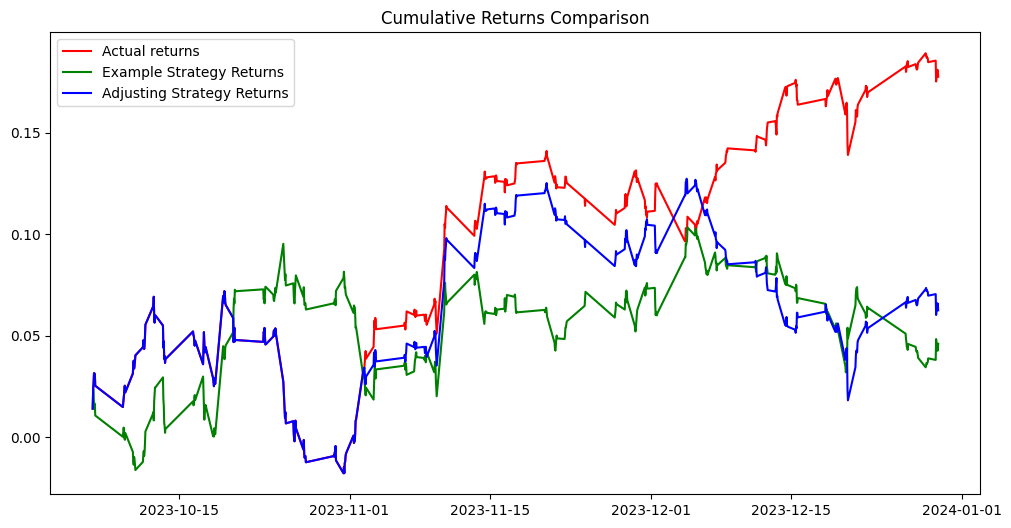

In [10]:
#Strategy returns
returns = df.copy()
returns['Predicted_Model2_Signal'] = model2.predict(X2)
returns['Predicted_Model3_Signal'] = model3.predict(X3)

returns['Standard_returns'] = np.log(returns['Close']/returns['Close'].shift(1))
Cumulative_Standard_returns = np.cumsum(returns[split:]['Standard_returns'])

returns['Model2_returns'] = returns['Standard_returns'] * returns['Predicted_Model2_Signal'].shift(1)
Cumulative_Model2_returns = np.cumsum(returns[split:]['Model2_returns'])

returns['Model3_returns'] = returns['Standard_returns'] * returns['Predicted_Model3_Signal'].shift(1)
Cumulative_Model3_returns = np.cumsum(returns[split:]['Model3_returns'])

plt.figure(figsize=(12,6))
plt.plot(Cumulative_Standard_returns, color='red', label = 'Actual returns')
plt.plot(Cumulative_Model2_returns, color='green', label = 'Example Strategy Returns')
plt.plot(Cumulative_Model3_returns, color='blue', label = 'Adjusting Strategy Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.show()